In [226]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')

## Reading the data

In [3]:
poll_df = pd.read_csv('expb.csv') # taken from https://votes21.bechirot.gov.il/

In [113]:
poll_df.columns = ['Yeshuv_name', 'Yeshuv_symbol', 'Poll_num', 'Bazab', 'Voters', 'Disqualified', 'Kosher',
                  'Emet', 'G', 'Daam', 'Wm', 'Z', 'Zi', 'Zkh', 'Zn', 'Ztz', 'Tb', 'Y', 'Yz', 'Yn', 'Ytz',
                  'K', 'Khk', 'L', 'Mhl', 'Mrtz', 'N', 'Nz', 'Nkh', 'Ntz', 'Nr', 'Nsofit', 'NNkh', 'Nnn', 'Ph',
                  'Fz', 'Fy', 'Fkh', 'Fn', 'Ftz', 'Tzk', 'Tz', 'Tzz', 'Tzi', 'TZEDEK', 'Ki', 'Knn', 'Kf', 'R',
                  'Shs']

votes_per_party = poll_df.iloc[:,7:].sum().sort_values(ascending=False)

votes_per_party.head() # validated against official summary in https://votes21.bechirot.gov.il/

Mhl    1140370
Ph     1125881
Shs     258275
G       249049
Wm      193442
dtype: int64

## Function

In [197]:
# votes to mandate - calculation based on https://bechirot21.bechirot.gov.il/election/about/Pages/CalculatingSeatsMethod.aspx

def voters_to_mandates(voter_dist,
                          odafim_dict = {'Emet':'Emet-Mrtz','Mrtz':'Emet-Mrtz',
                   'L':'L-N', 'N':'L-N',
                   'Wm':'Wm-Daam','Daam':'Wm-Daam',
                   'Mhl':'Mhl-Tb','Tb':'Mhl-Tb',
                   'Shs':'Shs-G','G':'Shs-G'
                   } #taken from Wikipedia https://he.wikipedia.org/wiki/%D7%94%D7%91%D7%97%D7%99%D7%A8%D7%95%D7%AA_%D7%9C%D7%9B%D7%A0%D7%A1%D7%AA_%D7%94%D7%A2%D7%A9%D7%A8%D7%99%D7%9D_%D7%95%D7%90%D7%97%D7%AA#%D7%94%D7%A1%D7%9B%D7%9E%D7%99_%D7%A2%D7%95%D7%93%D7%A4%D7%99%D7%9D):
                      ):
                       
    ## First step: who gets mandates?
    all_kosher_votes = voter_dist.sum()
    hasima = all_kosher_votes * (3.25 / 100)

    everyones_df = voter_dist.to_frame()
    everyones_df.columns = ['kosher_votes']
    everyones_df.loc[:,'pass_hasima'] = everyones_df['kosher_votes'] >= hasima

    ## Step two: first allocation
    gets_mandates_df = everyones_df.query("pass_hasima == True")
    moded_klali = gets_mandates_df['kosher_votes'].sum() / 120

    gets_mandates_df.loc[:,'first_allocation'] = np.floor((gets_mandates_df['kosher_votes'] / moded_klali)).astype('int')


    ## Step two: Bader-Ofer
    gets_mandates_df.loc[:,'odafim_agreement'] = gets_mandates_df.index
    gets_mandates_df = gets_mandates_df.replace(odafim_dict) 

    baderofer_df = gets_mandates_df.reset_index()
    baderofer_df = baderofer_df.replace(odafim_dict) 
    baderofer_df = baderofer_df.groupby('index').sum()

    remaining_mandates = 120 - gets_mandates_df['first_allocation'].sum()


    baderofer_df.loc[:,'mandates_baderofer'] = baderofer_df['first_allocation'].copy()

    for mandate in range(remaining_mandates):
        baderofer_df.loc[:,'moded_reshima'] = baderofer_df['kosher_votes'] / (baderofer_df['mandates_baderofer'] + 1)

        baderofer_df.loc[:,'mandates_baderofer'] = baderofer_df.apply(lambda x: x['mandates_baderofer'] + 1 
                                                        if x['moded_reshima'] == baderofer_df['moded_reshima'].max()
                                                        else x['mandates_baderofer'],
                           axis=1)

    baderofer_df = baderofer_df[['kosher_votes','pass_hasima','first_allocation','mandates_baderofer']]

    # Third step: dividing mandates between "odafim" partners

    unified_df = gets_mandates_df.reset_index().merge(baderofer_df.reset_index(),
                                         left_on='odafim_agreement', right_on='index', how='left')
    unified_df.set_index('index_x')

    final_df = pd.DataFrame()

    for agreement in gets_mandates_df['odafim_agreement'].unique():
        tmp_df = unified_df.query("odafim_agreement == '{}'".format(agreement)).copy()
        tmp_df.loc[:,'final_mandates'] = tmp_df['first_allocation_x'].copy()

        moded_pnimi = tmp_df['kosher_votes_y'].max() / tmp_df['mandates_baderofer'].max()

        odafim = int(tmp_df['mandates_baderofer'].max() - tmp_df['first_allocation_y'].max())

        if odafim == 2:
            tmp_df.loc[:,'final_mandates'] += 1
        elif odafim == 1:
            tmp_df.loc[:,'moded_reshima'] = tmp_df['kosher_votes_x'] / (tmp_df['first_allocation_y'] + 1)    
            tmp_df.loc[:,'final_mandates'] = tmp_df.apply(lambda x: x['final_mandates'] + 1 
                                                            if x['moded_reshima'] == tmp_df['moded_reshima'].max()
                                                            else x['final_mandates'],
                               axis=1)

        tmp_df = tmp_df.rename(columns={'index_x':'party','first_allocation_x':'first_allocation'})
        tmp_df = tmp_df.set_index('party')
        tmp_df = tmp_df[['kosher_votes_x','first_allocation','odafim_agreement','kosher_votes_y',
                        'mandates_baderofer','final_mandates']]

        final_df = pd.concat([final_df,tmp_df])

    return final_df.sort_values(by='final_mandates', ascending=False)

### Validation

In [103]:
voters_to_mandates(votes_per_party)

,kosher_votes_x,first_allocation,odafim_agreement,kosher_votes_y,mandates_baderofer,final_mandates
party,,,,,,
Mhl,1140370,34,Mhl-Tb,1299838,40.0,35
Ph,1125881,34,Ph,1125881,35.0,35
Shs,258275,7,Shs-G,507324,16.0,8
G,249049,7,Shs-G,507324,16.0,8
Wm,193442,5,Wm-Daam,337108,10.0,6
Emet,190870,5,Emet-Mrtz,347343,10.0,6
Tb,159468,4,Mhl-Tb,1299838,40.0,5
L,173004,5,L-N,173004,5.0,5
Daam,143666,4,Wm-Daam,337108,10.0,4


The "final mandates" column is validated against official mandate allocation, taken from https://votes21.bechirot.gov.il/

## Scenarios

In [104]:
# What would have been the mandates allocation if only "HaYamin Hahadash" voters would have turned out out of all
# voters for parties who hadn't passed the "hasima"?

just_yaminhadash_votes = votes_per_party[:12]
voters_to_mandates(just_yaminhadash_votes)

,kosher_votes_x,first_allocation,odafim_agreement,kosher_votes_y,mandates_baderofer,final_mandates
party,,,,,,
Mhl,1140370,33,Mhl-Tb,1299838,39.0,34
Ph,1125881,33,Ph,1125881,33.0,33
Shs,258275,7,Shs-G,507324,15.0,8
G,249049,7,Shs-G,507324,15.0,7
Wm,193442,5,Wm-Daam,337108,10.0,6
Emet,190870,5,Emet-Mrtz,347343,10.0,6
Tb,159468,4,Mhl-Tb,1299838,39.0,5
L,173004,5,L-N,311602,9.0,5
Daam,143666,4,Wm-Daam,337108,10.0,4


In [105]:
# What would have been the mandates allocation without the Likud-Mafdal odafim agreement?

voters_to_mandates(votes_per_party, odafim_dict={'Emet':'Emet-Mrtz','Mrtz':'Emet-Mrtz',
                   'L':'L-N', 'N':'L-N',
                   'Wm':'Wm-Daam','Daam':'Wm-Daam',
#                    'Mhl':'Mhl-Tb','Tb':'Mhl-Tb',
                   'Shs':'Shs-G','G':'Shs-G'
                   })

,kosher_votes_x,first_allocation,odafim_agreement,kosher_votes_y,mandates_baderofer,final_mandates
party,,,,,,
Mhl,1140370,34,Mhl,1140370,35.0,35
Ph,1125881,34,Ph,1125881,35.0,35
Shs,258275,7,Shs-G,507324,16.0,8
G,249049,7,Shs-G,507324,16.0,8
Wm,193442,5,Wm-Daam,337108,10.0,6
Emet,190870,5,Emet-Mrtz,347343,10.0,6
L,173004,5,L-N,173004,5.0,5
Tb,159468,4,Tb,159468,5.0,5
Daam,143666,4,Wm-Daam,337108,10.0,4


In [131]:
# What if the voting rate was 100% (assuming ballot-based voting distribution)?

## Add votes for every party based on the distribution of votes in each poll & "non voters" (based on Bazab)
parties =  ['Emet', 'G', 'Daam', 'Wm', 'Z', 'Zi', 'Zkh', 'Zn', 'Ztz', 'Tb', 'Y', 'Yz', 'Yn', 'Ytz',
            'K', 'Khk', 'L', 'Mhl', 'Mrtz', 'N', 'Nz', 'Nkh', 'Ntz', 'Nr', 'Nsofit', 'NNkh', 'Nnn', 'Ph',
            'Fz', 'Fy', 'Fkh', 'Fn', 'Ftz', 'Tzk', 'Tz', 'Tzz', 'Tzi', 'TZEDEK', 'Ki', 'Knn', 'Kf', 'R',
            'Shs']

t = poll_df.copy()
t.loc[:,'potential_votes'] = t['Bazab'] - t['Kosher']
poll_distribution = t[parties].divide(t.Kosher, axis=0)
added_votes_based_on_distribution = poll_distribution.multiply(t.potential_votes, axis=0).astype(int)
votes_if_everyone_voted = t[parties] + added_votes_based_on_distribution

In [125]:
votes_per_party_if_everyone_voted = votes_if_everyone_voted.sum()

In [127]:
votes_per_party_if_everyone_voted.sort_values(ascending=False).head(15)

Mhl     1640574
Ph      1560524
Wm       382443
Shs      368838
G        337292
Daam     297156
L        284971
Emet     261671
Mrtz     236841
K        219209
Tb       206225
N        177467
Z        150737
Nr       100006
R          7511
dtype: int64

In [128]:
delta = votes_per_party_if_everyone_voted - votes_per_party
delta.sort_values(ascending=False)

Mhl       500204
Ph        434643
Wm        189001
Daam      153490
L         111967
Shs       110563
G          88243
Mrtz       80368
Emet       70801
K          66453
Tb         46757
N          38869
Z          32706
Nr         25305
R           3376
Ntz         1701
Nsofit      1363
Tzk         1356
TZEDEK       657
Kf           488
Y            456
Ztz          379
Nz           360
Fy           357
Khk          255
Tzi          232
Ftz          227
Ki           221
Tz           210
Knn          190
Zi           183
Fn           152
Nnn          151
Fkh          148
Yn           141
Ytz          128
Fz           121
Yz            90
Zkh           62
NNkh          34
Tzz            0
Nkh            0
Zn             0
dtype: int64

In [199]:
voters_to_mandates(votes_per_party_if_everyone_voted)

,kosher_votes_x,first_allocation,odafim_agreement,kosher_votes_y,mandates_baderofer,final_mandates
party,,,,,,
Mhl,1640574,33,Mhl-Tb,1846799,39.0,34
Ph,1560524,32,Ph,1560524,33.0,33
Shs,368838,7,Shs-G,706130,14.0,8
Wm,382443,7,Wm-Daam,679599,14.0,8
Emet,261671,5,Emet-Mrtz,498512,10.0,6
G,337292,6,Shs-G,706130,14.0,6
Daam,297156,6,Wm-Daam,679599,14.0,6
L,284971,5,L-N,284971,6.0,6
Tb,206225,4,Mhl-Tb,1846799,39.0,5


In [204]:
votes_per_party_if_everyone_voted.sum() * 1.0 / t.Bazab.sum()

0.9892659449638935

In [205]:
 t.Kosher.sum() * 1.0 / t.Bazab.sum()

0.6797246380720691

In [241]:
comparison_df = voters_to_mandates(votes_per_party)[['final_mandates']].join(voters_to_mandates(votes_per_party_if_everyone_voted)[['final_mandates']],
                                                            lsuffix='_real', rsuffix='_100percturnout')
comparison_df['delta'] = comparison_df['final_mandates_100percturnout'] - comparison_df['final_mandates_real']
comparison_df.sort_values(by='delta', ascending=False)

,final_mandates_real,final_mandates_100percturnout,delta
party,,,
Wm,6,8,2
Daam,4,6,2
L,5,6,1
Shs,8,8,0
Emet,6,6,0
Tb,5,5,0
Mrtz,4,4,0
K,4,4,0
Mhl,35,34,-1


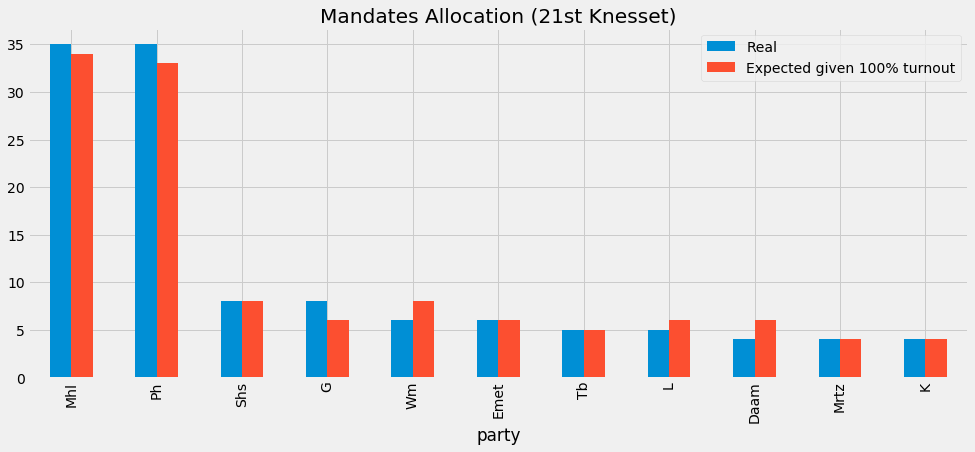

In [260]:
p = comparison_df[['final_mandates_real',
               'final_mandates_100percturnout']].sort_values(by='final_mandates_real',ascending=False).plot(kind='bar',
                             title='Mandates Allocation (21st Knesset)', figsize=(15,6))
p.legend(labels=['Real','Expected given 100% turnout'])

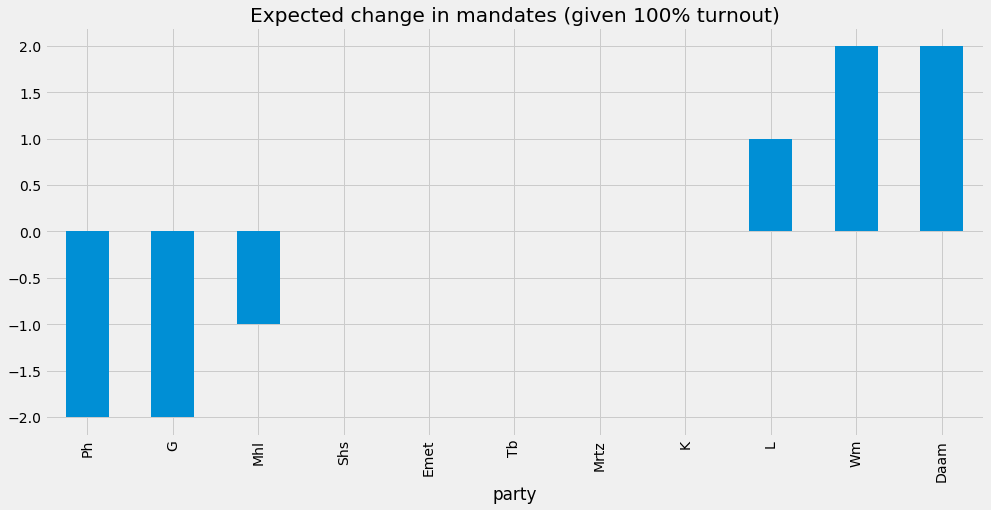

In [261]:
comparison_df[['delta']].sort_values(by='delta').plot(kind='bar',
                             title='Expected change in mandates (given 100% turnout)',
                            legend=False,figsize=(15,7))

In [144]:
# What if the voting rate was 100% (assuming yeshuv-based voting distribution)?

c = poll_df.copy()
yeshuv_df = c.groupby('Yeshuv_name').sum()

yeshuv_df.loc[:,'potential_votes'] = yeshuv_df['Bazab'] - yeshuv_df['Kosher']
yeshuv_distribution = yeshuv_df[parties].divide(yeshuv_df.Kosher, axis=0)
added_votes_based_on_distribution_yeshuv = yeshuv_distribution.multiply(yeshuv_df.potential_votes, axis=0).astype(int)
votes_if_everyone_voted_yeshuv = yeshuv_df[parties] + added_votes_based_on_distribution_yeshuv

In [203]:
votes_per_party_if_everyone_voted_yeshuv = votes_if_everyone_voted_yeshuv.sum()
voters_to_mandates(votes_per_party_if_everyone_voted_yeshuv)

,kosher_votes_x,first_allocation,odafim_agreement,kosher_votes_y,mandates_baderofer,final_mandates
party,,,,,,
Mhl,1640188,33,Mhl-Tb,1853699,39.0,34
Ph,1589132,32,Ph,1589132,33.0,33
Shs,375289,7,Shs-G,722672,15.0,8
Wm,374135,7,Wm-Daam,666395,14.0,8
G,347383,7,Shs-G,722672,15.0,7
Emet,268050,5,Emet-Mrtz,506287,10.0,6
Daam,292260,6,Wm-Daam,666395,14.0,6
Tb,213511,4,Mhl-Tb,1853699,39.0,5
L,271181,5,L-N,271181,5.0,5


In [219]:
comparison_df = voters_to_mandates(votes_per_party)[['final_mandates']].join(voters_to_mandates(votes_per_party_if_everyone_voted_yeshuv)[['final_mandates']],
                                                            lsuffix='_real', rsuffix='_100percturnout_yeshuv')
comparison_df['delta'] = comparison_df['final_mandates_100percturnout_yeshuv'] - comparison_df['final_mandates_real']
comparison_df.sort_values(by='delta', ascending=False)

,final_mandates_real,final_mandates_100percturnout_yeshuv,delta
party,,,
Wm,6,8,2
Daam,4,6,2
Shs,8,8,0
Emet,6,6,0
Tb,5,5,0
L,5,5,0
Mrtz,4,4,0
K,4,4,0
Mhl,35,34,-1


In [200]:
# What if the turnout rate was half as big, same distribution?

voters_to_mandates((votes_per_party / 2).astype(int))

,kosher_votes_x,first_allocation,odafim_agreement,kosher_votes_y,mandates_baderofer,final_mandates
party,,,,,,
Mhl,570185,34,Mhl-Tb,649919,40.0,35
Ph,562940,34,Ph,562940,35.0,35
Shs,129137,7,Shs-G,253661,16.0,8
G,124524,7,Shs-G,253661,16.0,8
Wm,96721,5,Wm-Daam,168554,10.0,6
Emet,95435,5,Emet-Mrtz,173671,10.0,6
Tb,79734,4,Mhl-Tb,649919,40.0,5
L,86502,5,L-N,86502,5.0,5
Daam,71833,4,Wm-Daam,168554,10.0,4


In [218]:
comparison_df = voters_to_mandates(votes_per_party)[['final_mandates']].join((voters_to_mandates((votes_per_party / 2).astype(int)))[['final_mandates']],
                                                            lsuffix='_real', rsuffix='_halfturnout')
comparison_df['delta'] = comparison_df['final_mandates_halfturnout'] - comparison_df['final_mandates_real']
comparison_df.sort_values(by='delta', ascending=False)

,final_mandates_real,final_mandates_halfturnout,delta
party,,,
Mhl,35,35,0
Ph,35,35,0
Shs,8,8,0
G,8,8,0
Wm,6,6,0
Emet,6,6,0
Tb,5,5,0
L,5,5,0
Daam,4,4,0


In [201]:
# What if the turnout rate was twice as big, same distribution?

voters_to_mandates(votes_per_party * 2)

,kosher_votes_x,first_allocation,odafim_agreement,kosher_votes_y,mandates_baderofer,final_mandates
party,,,,,,
Mhl,2280740,34,Mhl-Tb,2599676,40.0,35
Ph,2251762,34,Ph,2251762,35.0,35
Shs,516550,7,Shs-G,1014648,16.0,8
G,498098,7,Shs-G,1014648,16.0,8
Wm,386884,5,Wm-Daam,674216,10.0,6
Emet,381740,5,Emet-Mrtz,694686,10.0,6
Tb,318936,4,Mhl-Tb,2599676,40.0,5
L,346008,5,L-N,346008,5.0,5
Daam,287332,4,Wm-Daam,674216,10.0,4


In [217]:
comparison_df = voters_to_mandates(votes_per_party)[['final_mandates']].join((voters_to_mandates(votes_per_party * 2))[['final_mandates']],
                                                            lsuffix='_real', rsuffix='_doubleturnout')
comparison_df['delta'] = comparison_df['final_mandates_doubleturnout'] - comparison_df['final_mandates_real']
comparison_df.sort_values(by='delta', ascending=False)

,final_mandates_real,final_mandates_doubleturnout,delta
party,,,
Mhl,35,35,0
Ph,35,35,0
Shs,8,8,0
G,8,8,0
Wm,6,6,0
Emet,6,6,0
Tb,5,5,0
L,5,5,0
Daam,4,4,0
